In [1]:
import dataclasses
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import control as ct
import control.matlab as matlab

In [2]:
@dataclasses.dataclass
class BoostParams:
    R_L: float
    L: float
    C: float
    R: float
    V_i: float
    D: float
    T: float

The operating points of the system are
$$\begin{gather} 
\frac{1-D_o^*}{R}V_o^* - I_L^* &= 0 \\
V_o^* + (1 - D^*)R_L I_L^* &= (1-D_o^*)V_i
\end{gather}$$

In [3]:
def get_operating_point(params: BoostParams):
    A = np.array([[(1 - params.D) / params.R, -1],
                 [1, (1 - params.D) * params.R_L]])
    b = np.array([0, (1 - params.D) * params.V_i])
    
    return np.linalg.inv(A) @ b

The linearized system is
$$\begin{bmatrix} \delta \dot{V_o} \\ \delta \dot{I_L} \end{bmatrix}
 = \begin{bmatrix}-\frac{1}{RC} & \frac{1}{C} - \frac{D^*}{C} \\ \frac{D^* - 1}{L} & -\frac{R_L}{L}\end{bmatrix}
 \begin{bmatrix}\delta V_o \\ \delta I_L \end{bmatrix}
 + \begin{bmatrix} -\frac{I_L^*}{C} \\ \frac{V_o^*}{L}\end{bmatrix}\delta D
$$

In [27]:
def get_ss_system(params: BoostParams):
    V_o, I_L = get_operating_point(params)
    
    A = np.array([[- 1 / (params.R * params.C), (1 - params.D) / params.C],
                  [(params.D - 1) / params.L, - params.R_L / params.L]])
    B = np.array([[-I_L / params.C],[V_o / params.L]])
    
    return ct.StateSpace(A, B, np.array([1, 0]), 0)

In [40]:
my_params = BoostParams(R_L = 1.2, L=660e-6, C=100e-6, R=1e3, V_i=4.5, D=0.5, T=1/50e3)
plant = get_ss_system(my_params)

In [29]:
plant.poles(), plant.zeros()

(array([-914.09090909+1723.51339304j, -914.09090909-1723.51339304j]),
 array([1513333.33333333+0.j]))

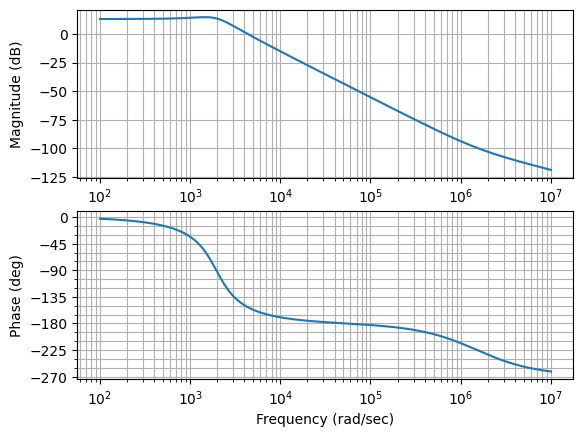

In [30]:
_ = matlab.bode(plant, dB=True)

In [36]:
controller = ct.TransferFunction([0.05, 1], [1, 0])

feedback_system = ct.series(controller, plant).feedback()
feedback_system.poles(), feedback_system.zeros()

(array([  -3.65990219   +0.j        , -911.97979235+1954.13955635j,
        -911.97979235-1954.13955635j]),
 array([-2.00000000e+01+0.j,  1.51333333e+06+0.j]))

In [47]:
feedback_system

StateSpace(array([[ 0.00000000e+00, -1.00000000e+00,  0.00000000e+00],
       [-1.12466260e+01, -9.43766870e+00,  5.00000000e+03],
       [ 3.40806849e+03, -9.27979182e+02, -1.81818182e+03]]), array([[  1.        ],
       [ -0.5623313 ],
       [170.40342443]]), array([[0., 1., 0.]]), array([[0.]]))

In [46]:
controller

TransferFunction(array([0.05, 1.  ]), array([1, 0]))

In [44]:
feedback_tf = (controller * plant) / (1 + controller * plant)
feedback_tf

TransferFunction(array([-5.62331301e-01,  8.49955411e+05,  1.57063211e+09,  3.27001007e+12,
        6.47787482e+13,  0.00000000e+00]), array([1.00000000e+00, 3.65580131e+03, 1.18043254e+07, 1.54869737e+10,
       1.77561074e+13, 6.47787482e+13, 0.00000000e+00]))

In [45]:
feedback_tf.poles()

array([-911.97979235+1954.13955635j, -911.97979235-1954.13955635j,
       -914.09090909+1723.51339304j, -914.09090909-1723.51339304j,
         -3.65990219   +0.j        ,    0.           +0.j        ])

In [37]:
feedback_system.dcgain()

1.0

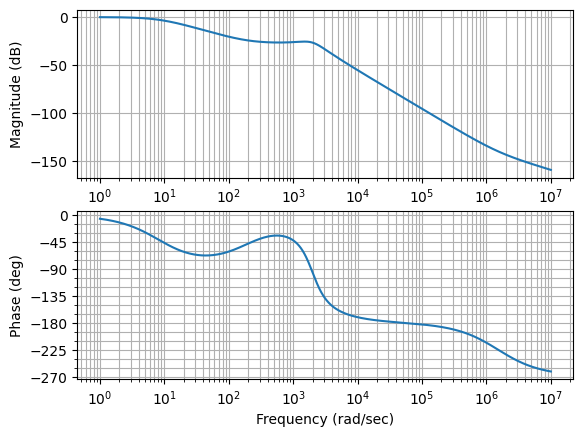

In [33]:
_ = matlab.bode(feedback_system)